In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
# import dataset_generation
# import gcm_filtering
import gcm_filters
import os
import xrft

warnings.filterwarnings("ignore")

#import aerobulk
#from aerobulk import noskin

# importlib.reload(dataset_generation)
# from dataset_generation import preprocess_data, filter_inputs_dataset, compute_heatflux

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/8787/status,
Dashboard: /user/panalluri/proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 125.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42889,Workers: 0
Dashboard: /user/panalluri/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45417,Total threads: 2
Dashboard: /user/panalluri/proxy/42401/status,Memory: 15.73 GiB
Nanny: tcp://127.0.0.1:46193,


# Useful Functions

In [3]:
def crop_boxes(ds, boxes, max_points=150):
    """
    Crop dataset into regional boxes.

    Parameters
    ----------
    ds : xr.Dataset or xr.DataArray
        Input dataset with dimensions (time, yt_ocean, xt_ocean).
    boxes : list of tuples
        Each tuple defines (lat_min, lat_max, lon_min, lon_max).
    max_points : int, optional
        Max number of lat/lon points to keep in each cropped box.

    Returns
    -------
    cropped_boxes : list of xr.Dataset
        List of cropped boxes, with Boxes 11 & 12 concatenated.
    """
    
    cropped_boxes = []
    
    for i, (lat_min, lat_max, lon_min, lon_max) in enumerate(boxes, start=1):
        # Slice the box
        da_box = ds.sel(
            yt_ocean=slice(lat_min, lat_max),
            xt_ocean=slice(min(lon_min, lon_max), max(lon_min, lon_max))
        )

        # Trim to max_points in each direction
        lat_len = min(max_points, da_box.yt_ocean.size)
        lon_len = min(max_points, da_box.xt_ocean.size)
        da_box = da_box.isel(
            yt_ocean=slice(0, lat_len),
            xt_ocean=slice(0, lon_len)
        )

        # Shift Box 12 longitudes
        if i == 12:
            da_box = da_box.assign_coords(xt_ocean=da_box.xt_ocean + 360)

        cropped_boxes.append(da_box)

    # Concatenate Boxes 11 & 12
    if len(cropped_boxes) >= 12:
        combined_11_12 = xr.concat(cropped_boxes[10:12], dim="xt_ocean")
        del cropped_boxes[10:12]
        cropped_boxes.append(combined_11_12)

    return cropped_boxes

# Data Preprocessing

In [4]:
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_Yr3.zarr", engine="zarr", chunks={}) 
ds_LR = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_Yr3.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_Yr3.zarr", engine="zarr", chunks={}) 

In [5]:
ds_QLQH = xr.open_dataset("gs://leap-persistent/panalluri/ds_Yr3_QL.zarr", engine="zarr", chunks={}) 

In [6]:
ds_HR = ds_HR.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_LR = ds_LR.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_HF = ds_HF.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

ds_HR = ds_HR.drop_vars(["rh_ref", "u_ocean", "u_ref", "wind", "v_ocean", "v_ref"])
ds_LR = ds_LR.drop_vars(["rh_ref", "u_ocean", "u_ref", "wind", "v_ocean", "v_ref"])

In [7]:
box_names = [
    "Gulf Stream",
    "South Atlantic",
    "Equator Atlantic",
    "Malvinas Current",
    "California Current",
    "South Pacific",
    "Kuroshio Extension",
    "North Pacific",
    "Southern Ocean (NZ)",
    "Agulhas Current",
    "Indian Ocean",
    "Arabian Sea"
]

In [8]:
boxes = [
    (30, 45, -55, -40),
    (-30, -15, -25, -10),
    (-8, 8, -30, -15),
    (-55, -40, -55, -40),
    (30, 45, -140, -125),
    (-45, -30, -140, -125),
    (25, 40, -215, -200),
    (10, 25, -180, -165),
    (-60, -45, -175, -160),
    (-55, -40, 20, 35),
    (-25, -10, 70, 79.95),        # Box 11
    (-25, -10, -279.95, -275),    # Box 12
    (0, 15, 55, 70)
]

cropped_boxes_HR = crop_boxes(ds_HR, boxes, max_points=150)
cropped_boxes_LR = crop_boxes(ds_LR, boxes, max_points=150)
cropped_boxes_HF = crop_boxes(ds_HF, boxes, max_points=150)

In [10]:
ql, qh, taux, tauy, evap =  noskin(
        ds_HR.surface_temp,
        ds_HR.t_ref,
        ds_HR.q_ref,
        ds_HR.u_relative,
        ds_HR.v_relative,
        slp=ds_HR.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux = qh + ql

NameError: name 'noskin' is not defined

In [9]:
cropped_boxes_qh = crop_boxes(ds_QLQH.qh, boxes, max_points=150)
cropped_boxes_ql = crop_boxes(ds_QLQH.ql, boxes, max_points=150)

# Save Data

In [9]:
# assume you have ql and qh already computed as DataArrays
# and they share the same dims as cropped_boxes_HR[0][["xt_ocean","yt_ocean","time"]]

heatflux = xr.Dataset(
    {
        "ql": (["time", "yt_ocean", "xt_ocean"], ql.data),
        "qh": (["time", "yt_ocean", "xt_ocean"], qh.data),
    },
    coords={
        "time": ql.time,
        "yt_ocean": ql.yt_ocean,
        "xt_ocean": ql.xt_ocean,
    },
    attrs={"description": "Precomputed latent and sensible heat fluxes"}
)
heatflux

<xarray.Dataset>
Dimensions:   (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 0183-01-01 12:00:00 ... 0183-12-31 12:00:00
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
Data variables:
    ql        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 2700, 3600), meta=np.ndarray>
    qh        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 2700, 3600), meta=np.ndarray>
Attributes:
    description:  Precomputed latent and sensible heat fluxes

In [13]:
%%time

store_path = "gs://leap-persistent/panalluri/ds_Yr3_QL.zarr"
chunk_size = 5
dataset = heatflux
num_chunks = len(dataset.time) // chunk_size  # 1461

for i in range(num_chunks):
    t_start = i * chunk_size
    t_end = (i + 1) * chunk_size
    ds_chunk = dataset.isel(time=slice(t_start, t_end))
    
    # Print the actual time values being written
    print(f"Chunk {i}: Writing timesteps from {t_start} to {t_end}")
    
    if i == 0:
        # First write: create the dataset
        ds_chunk.to_zarr(store_path, mode="w", compute=True, zarr_version=2)
    else:
        # Append subsequent chunks along time
        ds_chunk.to_zarr(store_path, mode="a", append_dim="time", compute=True, zarr_version=2)

Chunk 0: Writing timesteps from 0 to 5
Chunk 1: Writing timesteps from 5 to 10
Chunk 2: Writing timesteps from 10 to 15
Chunk 3: Writing timesteps from 15 to 20
Chunk 4: Writing timesteps from 20 to 25
Chunk 5: Writing timesteps from 25 to 30
Chunk 6: Writing timesteps from 30 to 35
Chunk 7: Writing timesteps from 35 to 40
Chunk 8: Writing timesteps from 40 to 45
Chunk 9: Writing timesteps from 45 to 50
Chunk 10: Writing timesteps from 50 to 55
Chunk 11: Writing timesteps from 55 to 60
Chunk 12: Writing timesteps from 60 to 65
Chunk 13: Writing timesteps from 65 to 70
Chunk 14: Writing timesteps from 70 to 75
Chunk 15: Writing timesteps from 75 to 80
Chunk 16: Writing timesteps from 80 to 85
Chunk 17: Writing timesteps from 85 to 90
Chunk 18: Writing timesteps from 90 to 95
Chunk 19: Writing timesteps from 95 to 100
Chunk 20: Writing timesteps from 100 to 105
Chunk 21: Writing timesteps from 105 to 110
Chunk 22: Writing timesteps from 110 to 115
Chunk 23: Writing timesteps from 115 to 

# Power Spectra Plotting

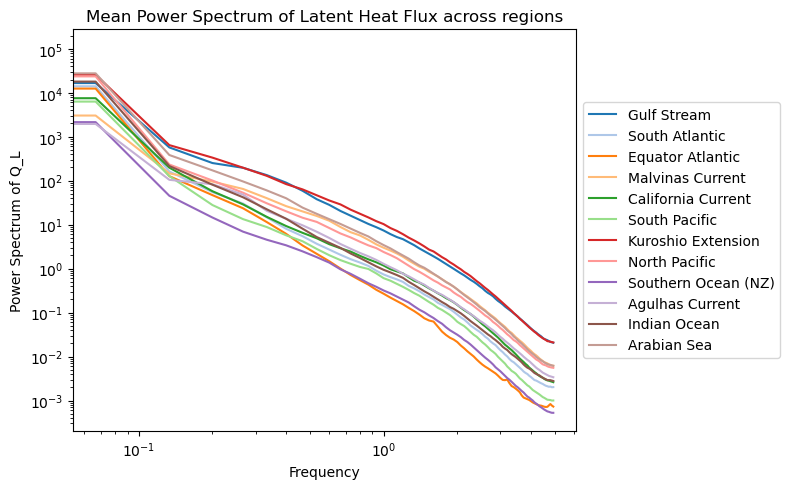

In [10]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    # q_diff = air–sea humidity difference
    ql = cropped_boxes_ql[i]

    power_specs = []
    for t in ql.time:
        ql_t = ql.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})

        # Compute 1D power spectrum along x-direction
        ps_t = xrft.power_spectrum(
            ql_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')  # average across y

        power_specs.append(ps_t)

    # Average spectra across time
    power_spec_mean = xr.concat(power_specs, dim="time").mean(dim="time")

    # Plot
    plt.plot(
        power_spec_mean["freq_xt_ocean"],
        np.abs(power_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Power Spectrum of Q_L")
plt.title("Mean Power Spectrum of Latent Heat Flux across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()


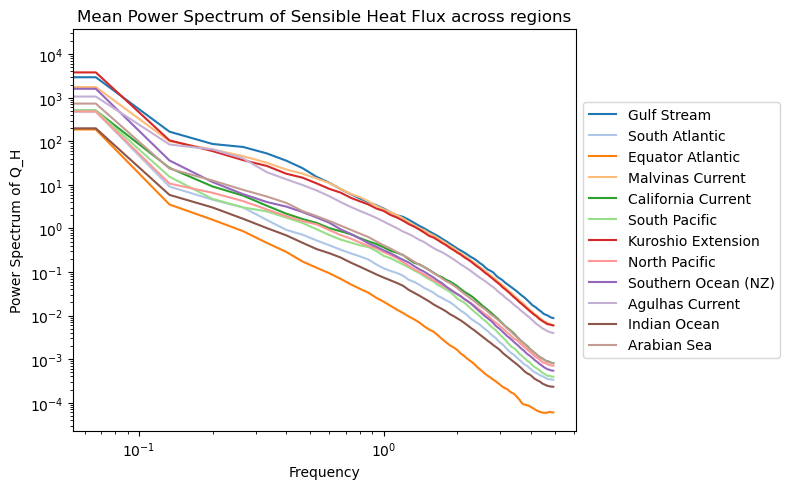

In [11]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    # q_diff = air–sea humidity difference
    qh = cropped_boxes_qh[i]

    power_specs = []
    for t in qh.time:
        qh_t = qh.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})

        # Compute 1D power spectrum along x-direction
        ps_t = xrft.power_spectrum(
            qh_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')  # average across y

        power_specs.append(ps_t)

    # Average spectra across time
    power_spec_mean = xr.concat(power_specs, dim="time").mean(dim="time")

    # Plot
    plt.plot(
        power_spec_mean["freq_xt_ocean"],
        np.abs(power_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Power Spectrum of Q_H")
plt.title("Mean Power Spectrum of Sensible Heat Flux across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()


# Cross-Spectrum Plotting

In [11]:
# constants
eps = 0.622
Lv = 2.5e6  # J/kg
rho_air = 1.2  # kg/m3

# Magnus/Bolton function
def es_hpa_from_t(T_c):
    return 6.112 * np.exp(17.67 * T_c / (T_c + 243.5))

# unit converters
def ensure_celsius(x):
    if x.mean().values > 200:  # Kelvin -> Celsius
        return x - 273.15
    return x

def ensure_pa(p):
    if p.mean().values < 2000:  # hPa -> Pa
        return p * 100.0
    return p

# container for qs arrays
qs_list = []

for i, box in enumerate(cropped_boxes_HR):
    # convert units
    SST_c = ensure_celsius(box.surface_temp)
    Tair_c = ensure_celsius(box.t_ref)
    p_surf = ensure_pa(box.slp)
    qa = box.q_ref

    # compute saturation specific humidity at SST
    es_sst_pa = (es_hpa_from_t(SST_c) * 100.0).astype(float)  # Pa
    qs = (eps * es_sst_pa) / (p_surf - (1 - eps) * es_sst_pa)

    # store as DataArray (preserving coords/dims if present)
    qs_da = xr.DataArray(qs, coords=box.surface_temp.coords, dims=box.surface_temp.dims)
    qs_list.append(qs_da)

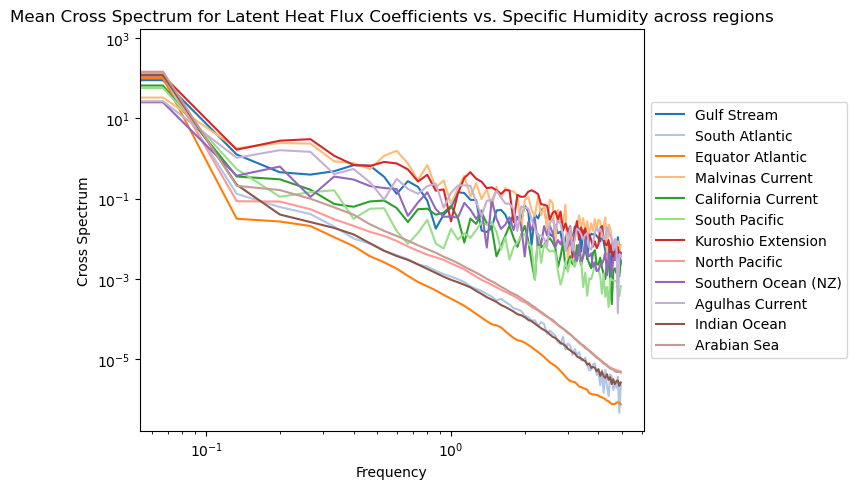

In [ ]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    q_diff = cropped_boxes_HR[i].q_ref - qs_list[i]
    C = cropped_boxes_ql[i] / q_diff

    cross_specs = []
    for t in q_diff.time:
        q_diff_t = q_diff.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        
        cross_spec_t = xrft.cross_spectrum(
            q_diff_t,
            C_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum")
plt.title("Mean Cross Spectrum for Latent Heat Flux Coefficients vs. Specific Humidity Difference across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

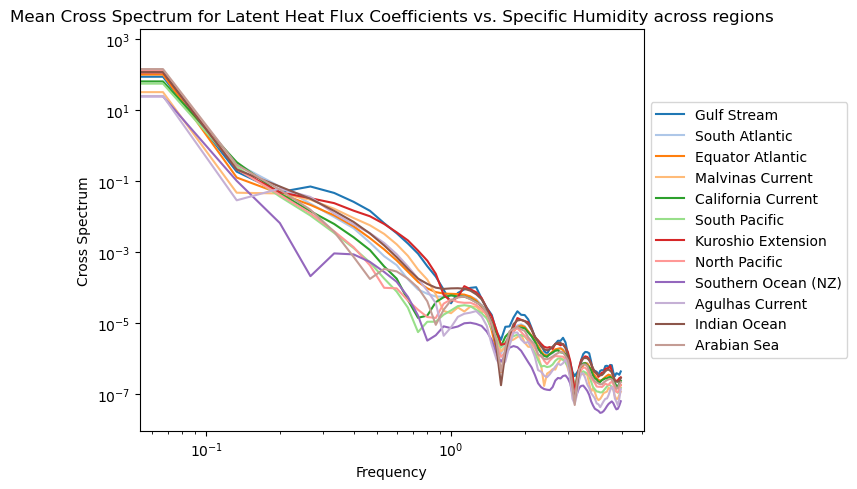

In [13]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    q = cropped_boxes_HR[i].q_ref
    C = cropped_boxes_ql[i] / q

    cross_specs = []
    for t in q.time:
        q_t = q.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        
        cross_spec_t = xrft.cross_spectrum(
            q_t,
            C_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum")
plt.title("Mean Cross Spectrum for Latent Heat Flux Coefficients vs. Specific Humidity across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

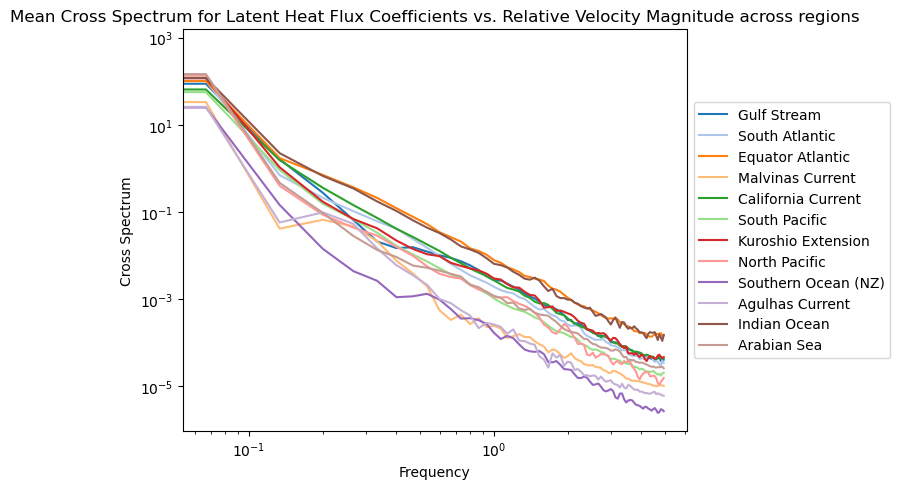

In [22]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    vel_mag = ( cropped_boxes_HR[i].u_relative **2 + cropped_boxes_HR[i].v_relative **2) ** 0.5
    C = cropped_boxes_ql[i] / vel_mag

    cross_specs = []
    for t in vel_mag.time:
        vel_mag_t = vel_mag.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        
        cross_spec_t = xrft.cross_spectrum(
            vel_mag_t,
            C_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum")
plt.title("Mean Cross Spectrum for Latent Heat Flux Coefficients vs. Relative Velocity Magnitude across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

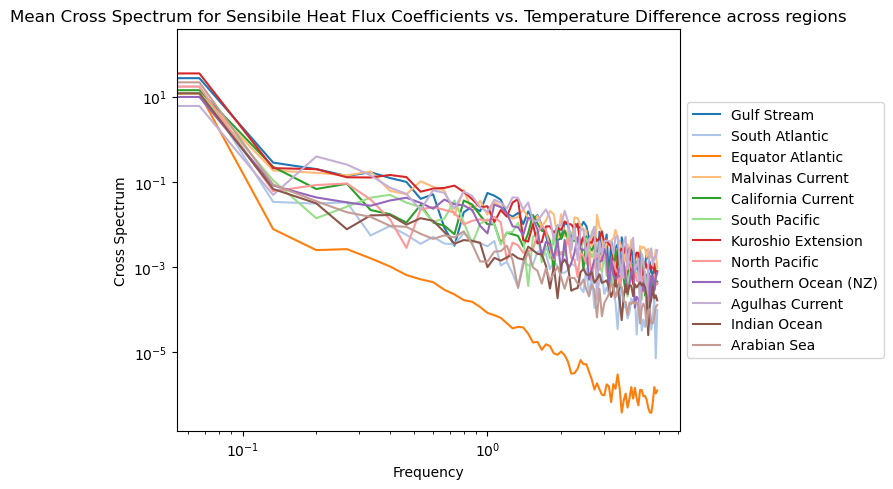

In [17]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    eps = 1e-6
    T_diff = cropped_boxes_HR[i].surface_temp - cropped_boxes_HR[i].t_ref
    C = cropped_boxes_qh[i] / (T_diff + 1e-6)

    cross_specs = []
    for t in T_diff.time:
        T_diff_t = T_diff.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        
        cross_spec_t = xrft.cross_spectrum(
            T_diff_t,
            C_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum")
plt.title("Mean Cross Spectrum for Sensibile Heat Flux Coefficients vs. Temperature Difference across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

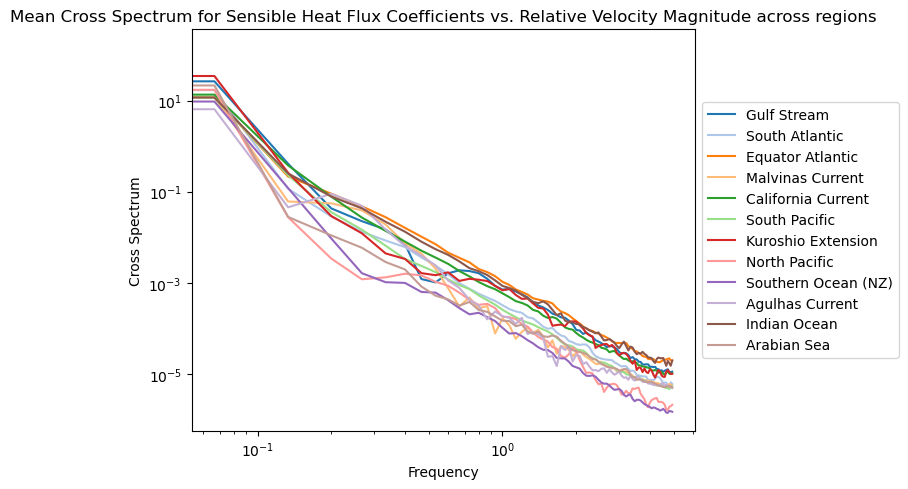

In [11]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    vel_mag = ( cropped_boxes_HR[i].u_relative **2 + cropped_boxes_HR[i].v_relative **2) ** 0.5
    C = cropped_boxes_qh[i] / vel_mag

    cross_specs = []
    for t in vel_mag.time:
        vel_mag_t = vel_mag.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        
        cross_spec_t = xrft.cross_spectrum(
            vel_mag_t,
            C_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum")
plt.title("Mean Cross Spectrum for Sensible Heat Flux Coefficients vs. Relative Velocity Magnitude across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()